In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import h5py
import pandas as pd
import numpy as np
import flatdict
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.models.models import HRTF_FIELD
from src.metrics import lsd, eusipco_metrics

from eusipco23.eusipco_main import make_data


In [13]:
data_dir = Path('../../../Dataset/SPEAR22/Miscellaneous/Array_Transfer_Functions/Device_ATFs.h5')

# DESCRIPTION: returns dictionary of array's Acoustic Impulse Responses (AIRs) for all measured directions
# *** OUTPUTS ***
# AIR        (dict) dictionary {'IR': (nSample,nDirection,nChannel),'fs': (int),'directions': (N,2),'nChan': (int)}
AIR = {'IR': [],'fs': [],'directions': [],'nChan': [], 'azi': [], 'ele': []}
# IR: (ndarray) Impulse Responses [nSample x nDirection x nChan]
# fs: (int) sample rate in Hz
# directions: (ndarray) (azimuth,elevation) in radians [nDirection x 2] 
# nChan: (int) number of array's sensor/channel
# azi: sorted unique azimuths (radians) [nDirection x 1]
# ele: sorted unique elevations (radians) [nDirection x 1]
f = h5py.File(data_dir,'r')
AIR['fs'] = int(list(f['SamplingFreq_Hz'])[0][0])
AIR['IR'] = np.array(f['IR']) # (ndarray) [nSample x nDirection x nChan]
AIR['ele'] = (np.pi/2)-np.array(f['Theta']) # (ndarray) elevation in radians [1 x nDirection]
AIR['azi'] = np.array(f['Phi']) # (ndarray) azimuth in radians [1 x nDirection]
AIR['directions'] = np.concatenate((AIR['azi'],AIR['ele']),axis=0).T # (ndarray) [nDirection x 2]
AIR['ele'] = np.sort(np.unique(AIR['ele'])) # (ndarray) [nElevation x 1]
AIR['azi'] = np.sort(np.unique(AIR['azi'])) # (ndarray) [nAzimuth x 1]
AIR['nChan'] = AIR['IR'].shape[-1]
f.close()

rirs = AIR['IR']
print(rirs.shape)

(768, 1020, 6)


# MODEL COMPARISON

In [14]:
exp_paths = [Path('./evaluation/super_resolution_freqs_out/').glob("*"),
            Path('./evaluation/super_resolution_freqs_in/').glob("*"),
            Path('./evaluation/super_resolution_baseline/').glob("*")
]
# exp_paths = [Path('./evaluation/baseline/').glob("*"),
#             Path('./evaluation/best_arch_freqs_in/').glob("*"),
#             Path('./evaluation/best_arch_freqs_out/').glob("*")
# ]

exp_dicts = []
for exp_dirs in exp_paths:
    for exp_dir in exp_dirs:

        path_to_res =  exp_dir / Path("results.pkl")
        if not path_to_res.exists():
            continue
        # load config file
        with open(path_to_res, 'rb') as fdtype:
            results = pickle.load(fdtype)
        conf = dict(flatdict.FlatDict(results['conf'], delimiter='.'))
        res = dict(flatdict.FlatDict(results['metrics'], delimiter='.'))
        del res['val.rmse_phase_freq']
        del res['diff.rmse_phase_freq']
        del res['test.rmse_phase_freq']
        del res['val.lsd_freq']
        del res['diff.lsd_freq']
        del res['test.lsd_freq']
        conf['exp_dir'] = exp_dir.resolve()
        conf["dir"] = exp_dir.name.split("_")[-1]
        exp_dicts.append( conf | res )

In [15]:
df = pd.DataFrame(exp_dicts)
df

,data_h5,seed,ds,grid_type,grid_pattern,model,n_mics,exp_dir,batch_size,epochs,...,diff.rmse_phase,diff.rmse_time,diff.lsd,diff.coherence,test.rmse_phase,test.rmse_time,test.lsd,test.coherence,test.time,train.time
0,Easycom_N-1020_fs-48k_nrfft-257.h5,666,90,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,1.397489,0.410366,4.155360,0.080704,1.247130,0.301622,2.722553,0.044413,0.197427,1305.465663
1,Easycom_N-1020_fs-48k_nrfft-257.h5,666,60,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,1.440839,0.459330,4.387731,0.105654,1.109480,0.320188,3.032490,0.051380,0.206458,2122.813645
2,Easycom_N-1020_fs-48k_nrfft-257.h5,666,15,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.037747,1.082948,7.996405,0.498961,1.906732,1.007565,7.452716,0.432676,0.289688,1398.951879
3,Easycom_N-1020_fs-48k_nrfft-257.h5,666,15,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.048195,1.058311,8.011869,0.495231,1.919041,0.984681,7.468743,0.429712,0.277034,1377.737649
4,Easycom_N-1020_fs-48k_nrfft-257.h5,666,75,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,1.461809,0.489821,4.249896,0.101610,0.999661,0.280597,2.524910,0.034041,0.321873,1275.304427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Easycom_N-1020_fs-48k_nrfft-257.h5,666,75,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.191707,1.084490,16.190558,0.735699,2.110811,0.974329,16.258451,0.603571,0.054464,471.712692
104,Easycom_N-1020_fs-48k_nrfft-257.h5,666,45,random,checkboard,scf,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.156222,1.098642,6.367122,0.617974,1.604885,0.814867,4.722517,0.339963,3.813838,0.000021
105,Easycom_N-1020_fs-48k_nrfft-257.h5,666,90,random,checkboard,scf,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.040191,1.038323,6.965852,0.567077,0.672511,0.328754,2.205532,0.056849,2.411886,0.000018
106,Easycom_N-1020_fs-48k_nrfft-257.h5,666,30,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,18,2000,...,2.204336,1.111605,17.292045,0.854273,2.160759,1.069946,17.323597,0.775061,0.165907,397.035437


In [16]:
# curr_df = df.loc[
#                 ((df["loss_air_lam"] == 1) & (df["loss_caus_lam"] == 0))
#                     & (df["architecture"].isin(['SIREN', "SIREN_PHASE_CASCADE"])
#                   )
# ]
curr_df = df.loc[(df["do_freqs_in"] == 1) & (df["n_mics"] == 6)]
# # # best freqs in for ds
# # pivot = pd.pivot_table(curr_df,
# #         index=["do_freqs_in", "architecture", "exp_dir"], 
# #         values=["test.rmse_time", "test.coherence", "test.lsd"], 
# #         aggfunc = ['min'])
# # pivot
# curr_df = curr_df.sort_values("diff.lsd", ascending=True)[:30]
# pivot = pd.pivot_table(curr_df[:30],
#         index=["do_freqs_in", "architecture", "exp_dir"], 
#         values=["test.rmse_time", "test.coherence", "test.lsd"], 
#         aggfunc = ['min'])
# pivot
curr_df = curr_df.sort_values("test.lsd", ascending=True)[:2]
curr_df

,data_h5,seed,ds,grid_type,grid_pattern,model,n_mics,exp_dir,batch_size,epochs,...,diff.rmse_phase,diff.rmse_time,diff.lsd,diff.coherence,test.rmse_phase,test.rmse_time,test.lsd,test.coherence,test.time,train.time
74,Easycom_N-1020_fs-48k_nrfft-257.h5,666,90,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,48,2000,...,1.415833,0.401598,3.627341,0.073022,1.278968,0.293521,2.431855,0.042139,7.124685,5079.517230
63,Easycom_N-1020_fs-48k_nrfft-257.h5,666,90,random,checkboard,dnn,6,/media/dicarlod/SSD_2/diego/Code/SteerAndInter...,48,2000,...,1.493021,0.476689,3.804910,0.100100,1.338970,0.327155,2.593288,0.055664,4.718537,2784.777647


In [17]:
pivot = pd.pivot_table(curr_df,
        index=["do_freqs_in", "architecture", "exp_dir"], 
        values=["test.rmse_time", "test.coherence", "test.lsd"], 
        aggfunc = ['min'])
pivot

min  \
                                                                                   test.coherence   
do_freqs_in architecture        exp_dir                                                             
1           SIREN_PHASE_CASCADE /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...       0.042139   
                                /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...       0.055664   

                                                                                              \
                                                                                    test.lsd   
do_freqs_in architecture        exp_dir                                                        
1           SIREN_PHASE_CASCADE /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...  2.431855   
                                /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...  2.593288   

                                                                                                   
                                                                                   test.rmse_time  
do_freqs_in architecture        exp_dir                                                            
1           SIREN_PHASE_CASCADE /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...       0.293521  
                                /media/dicarlod/SSD_2/diego/Code/SteerAndInterp...       0.327155

In [18]:
import seaborn
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5, 'font.family':'serif'})

(1, 'SIREN_PHASE_CASCADE', PosixPath('/media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe'))
min  test.coherence    0.042139
     test.lsd          2.431855
     test.rmse_time    0.293521
Name: (1, SIREN_PHASE_CASCADE, /media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe), dtype: float64
SIREN_PHASE_CASCADE
Input Data
(60, 17, 6, 257)
GT data: (60, 17, 2) (60, 17, 6, 257)
Remove angles and freqs
GT prune: (60, 17, 2) (60, 17, 6, 257)
Consider freqs and coordinates
GT exp: (60, 17, 257, 3) (60, 17, 257, 6)
Dowsample and flatten
DS: (1020, 257, 3) (1020, 257, 6)
3.204885793278799
mean 2.4488317205804853
mean_app 1.6083919956302282
3.1932262324968446
mean 2.4187212370814515
mean_app 1.6166004891917414
2.4428832650707686
mean 2.1198586135409356
mean_app 1.63497460229387


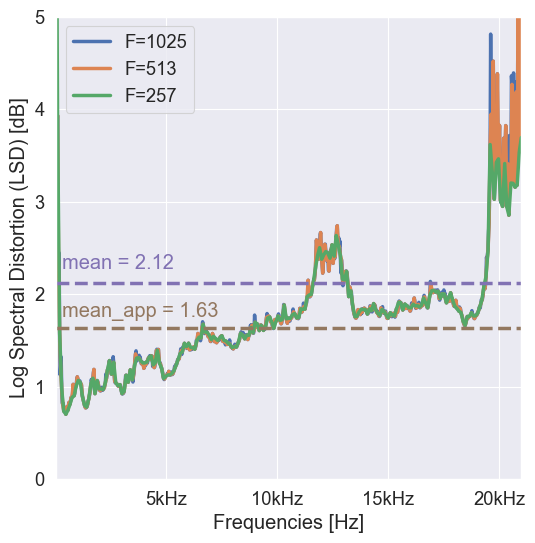

In [32]:
EPS = 1e-8
i = 0
for idx, row in pivot.iterrows():
    if i > 0: break
    i += 1

    do_freqs_in, architecture, path_to_res = idx

    if not do_freqs_in: continue

    print(idx)
    print(row)

    # load val
    with open(path_to_res / Path("results.pkl"), 'rb') as fdtype:
        results = pickle.load(fdtype)
    res = dict(flatdict.FlatDict(results['metrics'], delimiter='.'))
    lsd_freq = res['test.lsd_freq']
    
    if architecture == "SCF": continue
    print(architecture)

    data_conf = {
        "h5_path" : Path("../data/eusipco23/Easycom_N-1020_fs-48k_nrfft-257.h5"),
        "ind_mics" : [0,1,2,3,4,5],
        "features" : "atfs",
        "az_lim" : [0, 359], # degree
        "el_lim" : [-91,  91],  # degree
        "feat_lim" : [0, None],
        "grid_type" : "regular",
        "grid_pattern": "checkboard",
        "ds" : 1,
    }

    data_dict = make_data(data_conf, exp_dir)

    coords_grid = data_dict["gt"]["coords"]
    atfs = data_dict["gt"]["target"]

    n_rfft = atfs.shape[-2]
    n_fft = 2*(n_rfft-1)
    airs = np.fft.irfft(atfs, n=n_fft, axis=-2).real

    device = "cuda:0"

    fig = plt.figure(figsize=(6,6))

    for mul in [4,2,1]:

        _n_fft = int(mul*n_fft)
        atfs = np.fft.rfft(airs, n=_n_fft, axis=-2)
        n_rfft = atfs.shape[-2]

        az = coords_grid[:,0,0,0]
        el = coords_grid[0,:,0,1]
        fr = coords_grid[0,0,:,2]
        fr = np.linspace(0,1,n_rfft)

        if do_freqs_in:
            input_grid = np.stack(np.meshgrid(az,el,fr,indexing="ij"), axis=-1)
        else:
            input_grid = np.stack(np.meshgrid(az,el,indexing="ij"), axis=-1)

        coords = torch.from_numpy(input_grid).float().to(device)
        # coords = torch.from_numpy(coords_grid).float().to(device)

        best_model_dict = torch.load(path_to_res / Path("best_model.pth"))

        model = HRTF_FIELD(**best_model_dict["hparams"]).load_from_checkpoint(best_model_dict["path_to_checkpoint"])
        model = model.to(device)

        # eval
        
        est_atfs = model(coords)[0]
        est_atfs = est_atfs.detach().cpu().numpy()
        
        # est_airs = np.fft.irfft(est_atfs, n=n_fft, axis=-2).real
        eval_metrics = eusipco_metrics(est_atfs, atfs, _n_fft, dim=2)

        print(eval_metrics['lsd'])

        error = 20*(np.log10(np.abs(atfs)/np.abs(est_atfs)))
        error = np.sqrt(np.mean(error**2, axis=(0,1,-1)))
        print("mean", np.mean(error))
        mean_app = np.mean(error[10:int(0.8*n_rfft)])
        print("mean_app", np.mean(error[10:int(0.8*n_rfft)]))
        assert error.shape[0] == n_rfft

        freqs = np.linspace(0,AIR['fs']//2,n_rfft)
        plt.plot(freqs, error, label=f"F={n_rfft}")

        if mul == 1:
            plt.axhline(y=np.mean(error), c='C4', ls='--')
            plt.axhline(y=mean_app, c='C5', ls='--')
            plt.text(300, 1.07*np.mean(error), f'mean = {np.mean(error):1.2f}', c="C4")
            plt.text(300, 1.07*mean_app, f'mean_app = {mean_app:1.2f}', c="C5")
        # plt.plot(freqs*AIR['fs'], ref, label=f"{architecture}_ds-{ds}_n-fft={n_rfft}")    

    plt.xticks(ticks=[5000, 10000, 15000, 20000], labels=[f"{perc}kHz" for perc in [5, 10, 15, 20]])
    plt.xlim([40,21000])
    plt.ylim([0,5])
    plt.ylabel("Log Spectral Distortion (LSD) [dB]")
    plt.xlabel("Frequencies [Hz]")
    plt.legend()
    plt.savefig("./figures/freqs_super_res.pdf", dpi=150)
    plt.show()


(1, 'SIREN_PHASE_CASCADE', PosixPath('/media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe'))
min  test.coherence    0.042139
     test.lsd          2.431855
     test.rmse_time    0.293521
Name: (1, SIREN_PHASE_CASCADE, /media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe), dtype: float64
SIREN_PHASE_CASCADE
Input Data
(60, 17, 6, 257)
GT data: (60, 17, 2) (60, 17, 6, 257)
Remove angles and freqs
GT prune: (60, 17, 2) (60, 17, 6, 257)
Consider freqs and coordinates
GT exp: (60, 17, 257, 3) (60, 17, 257, 6)
Dowsample and flatten
DS: (1020, 257, 3) (1020, 257, 6)
3.204885793278799
mean 2.4488317205804853
mean_app 1.6083919956302282
3.1932262324968446
mean 2.4187212370814515
mean_app 1.6166004891917414
2.4428832650707686
mean 2.1198586135409356
mean_app 1.63497460229387


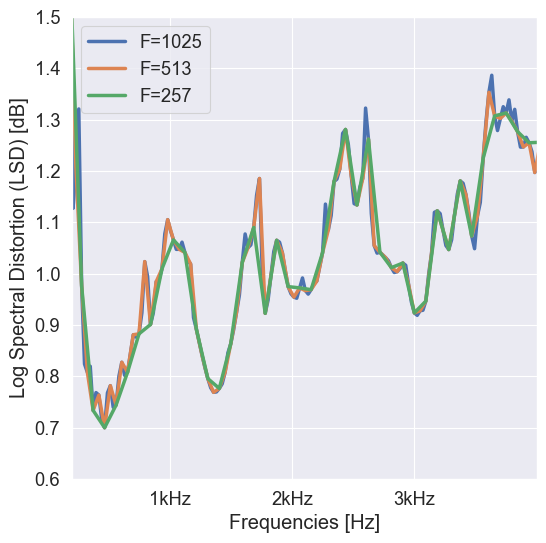

In [34]:
EPS = 1e-8
i = 0
for idx, row in pivot.iterrows():
    if i > 0: break
    i += 1

    do_freqs_in, architecture, path_to_res = idx

    if not do_freqs_in: continue

    print(idx)
    print(row)

    # load val
    with open(path_to_res / Path("results.pkl"), 'rb') as fdtype:
        results = pickle.load(fdtype)
    res = dict(flatdict.FlatDict(results['metrics'], delimiter='.'))
    lsd_freq = res['test.lsd_freq']
    
    if architecture == "SCF": continue
    print(architecture)

    data_conf = {
        "h5_path" : Path("../data/eusipco23/Easycom_N-1020_fs-48k_nrfft-257.h5"),
        "ind_mics" : [0,1,2,3,4,5],
        "features" : "atfs",
        "az_lim" : [0, 359], # degree
        "el_lim" : [-91,  91],  # degree
        "feat_lim" : [0, None],
        "grid_type" : "regular",
        "grid_pattern": "checkboard",
        "ds" : 1,
    }

    data_dict = make_data(data_conf, exp_dir)

    coords_grid = data_dict["gt"]["coords"]
    atfs = data_dict["gt"]["target"]

    n_rfft = atfs.shape[-2]
    n_fft = 2*(n_rfft-1)
    airs = np.fft.irfft(atfs, n=n_fft, axis=-2).real

    device = "cuda:0"

    fig = plt.figure(figsize=(6,6))

    for mul in [4,2,1]:

        _n_fft = int(mul*n_fft)
        atfs = np.fft.rfft(airs, n=_n_fft, axis=-2)
        n_rfft = atfs.shape[-2]

        az = coords_grid[:,0,0,0]
        el = coords_grid[0,:,0,1]
        fr = coords_grid[0,0,:,2]
        fr = np.linspace(0,1,n_rfft)

        if do_freqs_in:
            input_grid = np.stack(np.meshgrid(az,el,fr,indexing="ij"), axis=-1)
        else:
            input_grid = np.stack(np.meshgrid(az,el,indexing="ij"), axis=-1)

        coords = torch.from_numpy(input_grid).float().to(device)
        # coords = torch.from_numpy(coords_grid).float().to(device)

        best_model_dict = torch.load(path_to_res / Path("best_model.pth"))

        model = HRTF_FIELD(**best_model_dict["hparams"]).load_from_checkpoint(best_model_dict["path_to_checkpoint"])
        model = model.to(device)

        # eval
        
        est_atfs = model(coords)[0]
        est_atfs = est_atfs.detach().cpu().numpy()
        
        # est_airs = np.fft.irfft(est_atfs, n=n_fft, axis=-2).real
        eval_metrics = eusipco_metrics(est_atfs, atfs, _n_fft, dim=2)

        print(eval_metrics['lsd'])

        error = 20*(np.log10(np.abs(atfs)/np.abs(est_atfs)))
        error = np.sqrt(np.mean(error**2, axis=(0,1,-1)))
        print("mean", np.mean(error))
        mean_app = np.mean(error[10:int(0.8*n_rfft)])
        print("mean_app", np.mean(error[10:int(0.8*n_rfft)]))
        assert error.shape[0] == n_rfft

        freqs = np.linspace(0,AIR['fs']//2,n_rfft)
        plt.plot(freqs, error, label=f"F={n_rfft}")

        # plt.plot(freqs*AIR['fs'], ref, label=f"{architecture}_ds-{ds}_n-fft={n_rfft}")    

    plt.xticks(ticks=[1000, 2000, 3000, 5000, 10000, 15000, 20000], labels=[f"{perc}kHz" for perc in [1, 2, 3, 5, 10, 15, 20]])
    plt.xlim([200,4000])
    plt.ylim([0.6,1.5])
    plt.ylabel("Log Spectral Distortion (LSD) [dB]")
    plt.xlabel("Frequencies [Hz]")
    plt.legend()
    plt.savefig("./figures/freqs_super_res_close.pdf", dpi=150)
    plt.show()


In [38]:
EPS = 1e-8
i = 0
for idx, row in pivot.iterrows():
    if i > 0: break
    i += 1

    do_freqs_in, architecture, path_to_res = idx

    if not do_freqs_in: continue

    print(idx)
    print(row)

    # load val
    with open(path_to_res / Path("results.pkl"), 'rb') as fdtype:
        results = pickle.load(fdtype)
    res = dict(flatdict.FlatDict(results['metrics'], delimiter='.'))
    lsd_freq = res['test.lsd_freq']
    
    if architecture == "SCF": continue
    print(architecture)

    data_conf = {
        "h5_path" : Path("../data/eusipco23/Easycom_N-1020_fs-48k_nrfft-257.h5"),
        "ind_mics" : [0,1,2,3,4,5],
        "features" : "atfs",
        "az_lim" : [0, 359], # degree
        "el_lim" : [-91,  91],  # degree
        "feat_lim" : [0, None],
        "grid_type" : "regular",
        "grid_pattern": "checkboard",
        "ds" : 1,
    }

    data_dict = make_data(data_conf, exp_dir)

    coords_grid = data_dict["gt"]["coords"]
    atfs = data_dict["gt"]["target"]

    n_rfft = atfs.shape[-2]
    n_fft = 2*(n_rfft-1)
    airs = np.fft.irfft(atfs, n=n_fft, axis=-2).real

    device = "cuda:0"

    fig = plt.figure(figsize=(6,6))

    mul = 1

    _n_fft = int(mul*n_fft)
    atfs = np.fft.rfft(airs, n=_n_fft, axis=-2)
    n_rfft = atfs.shape[-2]

    az = coords_grid[:,0,0,0]
    el = coords_grid[0,:,0,1]
    fr = coords_grid[0,0,:,2]
    fr = np.linspace(0,1,n_rfft)

    if do_freqs_in:
        input_grid = np.stack(np.meshgrid(az,el,fr,indexing="ij"), axis=-1)
    else:
        input_grid = np.stack(np.meshgrid(az,el,indexing="ij"), axis=-1)

    coords = torch.from_numpy(input_grid).float().to(device)

    best_model_dict = torch.load(path_to_res / Path("best_model.pth"))

    model = HRTF_FIELD(**best_model_dict["hparams"]).load_from_checkpoint(best_model_dict["path_to_checkpoint"])
    model = model.to(device)

    
    est_atfs, extra = model(coords)
    toas = extra["toas_"]
    est_atfs = est_atfs.detach().cpu().numpy()
    
    # est_airs = np.fft.irfft(est_atfs, n=n_fft, axis=-2).real
    eval_metrics = eusipco_metrics(est_atfs, atfs, _n_fft, dim=2)

    Fs = AIR["fs"]  
    toas = Fs * (extra["toas_far_free"] + extra["global_delay_phase"])
    toas = int(toa)

    np.mean()

(1, 'SIREN_PHASE_CASCADE', PosixPath('/media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe'))
min  test.coherence    0.042139
     test.lsd          2.431855
     test.rmse_time    0.293521
Name: (1, SIREN_PHASE_CASCADE, /media/dicarlod/SSD_2/diego/Code/SteerAndInterp/eusipco23/evaluation/super_resolution_freqs_in/exp_SIREN_PHASE_CASCADE_9f96dafe), dtype: float64
SIREN_PHASE_CASCADE
Input Data
(60, 17, 6, 257)
GT data: (60, 17, 2) (60, 17, 6, 257)
Remove angles and freqs
GT prune: (60, 17, 2) (60, 17, 6, 257)
Consider freqs and coordinates
GT exp: (60, 17, 257, 3) (60, 17, 257, 6)
Dowsample and flatten
DS: (1020, 257, 3) (1020, 257, 6)


KeyError: 'toas_'

<Figure size 600x600 with 0 Axes>

tensor([[[[19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144],
          [19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144],
          [19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144],
          ...,
          [19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144],
          [19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144],
          [19.9202, 18.0345, 18.7489, 19.9650, 19.3090, 20.9144]],

         [[18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187],
          [18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187],
          [18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187],
          ...,
          [18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187],
          [18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187],
          [18.9006, 15.6852, 16.8136, 19.6557, 18.6461, 20.5187]],

         [[17.8938, 13.4279, 14.9425, 19.3405, 18.0022, 20.0959],
          [17.8938, 13.4279, 14.9425, 19.3405, 18.0022, 20.0959],
          [17.8938, 13.4279, 14.9425, 19.3

tensor([0.0004], device='cuda:0', grad_fn=<DivBackward0>)